# Set Environment

In [1]:
! pip install --q evaluate

In [2]:
import os
import re
import numpy as np

from pathlib import Path

import pandas as pd
import torch
import evaluate

from torch import nn
from tqdm.notebook import tqdm
from tokenizers import Tokenizer
from tokenizers import normalizers
from tokenizers import pre_tokenizers
from tokenizers.models import WordLevel, WordPiece
from tokenizers.processors import TemplateProcessing


from torch.utils.data import DataLoader, Dataset, Subset

from tokenizers.normalizers import NFC, StripAccents, Strip, Lowercase
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer

from sklearn.model_selection import train_test_split

2024-07-07 17:49:41.437086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 17:49:41.437194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 17:49:41.564199: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Helper 

In [3]:
# TODO : Class of myParameters

class Variables :
    PATHS = {
        'Data' : r'/kaggle/input/arabic-to-english-translation-sentences/ara_eng.txt',
        'HuggingFace':'zeyadusf/translation-EnAr',
    }
    
    TEXT ={
#         'vocab_size' : 200_000,
        'seq_len':64,
        'batch':128
    }
    
    TRANSFORMER = {
        'heads':16,
        'latent_dim':720,
        'pf_dim':1024,
        'dropout':0.4,
        'encoder_layers':6,
        'decoder_layers':6,
    }

     
        
    TRAIN = {
    'epoch'  : 250,
    'lr'     : 3e-4,
    'L2'     : 0.003,
    }
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
var = Variables()

In [4]:
# TODO : Cleaning data
punc_re = re.compile(r"""[!"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~،؟…«“\":\"…”]""")
def remove_punctation(text: str) -> str:
    return punc_re.sub(repl="", string=text)


diactircs_re = re.compile("[\u064B-\u0652]")
def remove_diactrics(text: str) -> str:
    return diactircs_re.sub(repl="", string=text)

def clean_text(text: str) -> str:
    return remove_punctation(remove_diactrics(text))


In [5]:
# TODO : utilities of creation and preparation data 
class TranslationDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.sort_values(by="length")
        
        self.src = df["source"].tolist()
        self.trg = df["target"].tolist()
                       
        
    def __getitem__(self, idx):
        source = self.src[idx]
        target = self.trg[idx]
        return (source, target)
        
    def __len__(self):
        return len(self.df)

def prepare_batch(batch, ar_tokenizer: Tokenizer, en_tokenizer: Tokenizer):
    ar = list(map(lambda x: x[0], batch))
    en = list(map(lambda x: x[1], batch))
    
    
    ar = ar_tokenizer.encode_batch(ar)
    en = en_tokenizer.encode_batch(en)
    
    
    
    ar_tokens = list(map(lambda x: x.ids, ar))
    ar_mask = list(map(lambda x: x.attention_mask, ar))
    en_tokens = list(map(lambda x: x.ids, en))
    en_mask = list(map(lambda x: x.attention_mask, en))

    
    source = torch.tensor(ar_tokens)
    source_mask = torch.tensor(ar_mask)
    target = torch.tensor(en_tokens)
    target_mask = torch.tensor(en_mask)
    return (source, source_mask, target, target_mask)

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# <p style="background-color:#100479; color:white;font-family:Gabriola;font-size:100%;text-align:center;border-radius:50px"><b> Transformer Layers </b></p>

### MultiHeadAttention

![md](https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11042-023-14981-2/MediaObjects/11042_2023_14981_Fig5_HTML.png)

![](https://miro.medium.com/max/469/1*GsLQLch51d7excmuAi4UzQ.png)

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_heads: int,
        dropout: float
    ):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.n_heads = n_heads
        self.head_dim = self.latent_dim // self.n_heads
        
        self.fc_q = nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)
        self.fc_k = nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)
        self.fc_v = nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)
        
        self.fc_o = nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
        
    def forward(self, query, key, value, mask = None):
        batch_size = query.shape[0]
        
        # query = [batch_size, query_len, latent_dim]
        # key = [batch_size, key_len, latent_dim]
        # value = [batch_size, value_len, latent_dim]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # Q = [batch_size, query_len, latent_dim]
        # K = [batch_size, key_len, latent_dim]
        # V = [batch_size, value_len, latent_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # Q = [batch_size, n_heads, query_len, head_dim]
        # K = [batch_size, n_heads, key_len, head_dim]
        # V = [batch_size, n_heads, value_len, head_dim]
        
        scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(query)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / scale
        # energy = [batch_size, n_heads, query_len, key_len]
        
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = self.dropout(torch.softmax(energy, dim=-1))
        # attention = [batch_size, n_heads, query_len, key_len]
        
        
        x = torch.matmul(attention, V)
        # x = [batch_size, n_heads, query_len, head_dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        # x = [batch_size, query_len, n_heads, head_dim]
        
        x = x.view(batch_size, -1, self.latent_dim)
        # x = [batch_size, query_len, latent_dim]
        
        x = self.fc_o(x)
        # x = [batch_size, query_len, latent_dim]
        
        return x, attention
    

### Positional Embedding

In [8]:
class PositionWiseFeedForward(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        pf_dim: int,
        dropout: float
    ):        
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=latent_dim, out_features=pf_dim)
        self.fc2 = nn.Linear(in_features=pf_dim, out_features=latent_dim)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        # x = [batch_size, seq_len, latent_dim]
        x = torch.relu(self.fc1(x))
        # x = [batch_size, seq_len, pf_dim]
        x = self.dropout(x)
        x = self.fc2(x)
        # x = [batch_size, seq_len, latent_dim]
        
        return x

### Encoder 

![](https://i.imgur.com/rbEe0lW.png)

In [9]:
class EncoderLayer(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_heads: int,
        pf_dim: int,
        dropout: float
    ):
        super().__init__()
        
        self.attention = MultiHeadAttention(latent_dim=latent_dim, n_heads=n_heads, dropout=dropout)
        self.positionwise_feedforward = PositionWiseFeedForward(latent_dim=latent_dim, pf_dim=pf_dim, dropout=dropout)
        
        self.attn_norm = nn.LayerNorm(normalized_shape=latent_dim)
        self.ppff_norm = nn.LayerNorm(normalized_shape=latent_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src, src_mask):
        # src = [batch_size, src_len, latent_dim]
        # src_mask = [batch_size, 1, 1, src_len]
        
        attention_values, _ = self.attention(src, src, src, src_mask)
        # attention_values = [batch_size, src_len, latent_dim]
        
        output = (attention_values + src)
        # output = [batch_size, src_len, latent_dim]
        
        ppff = self.positionwise_feedforward(output)
        # ppff = [batch_size, src_len, latent_dim]
        
        output = self.ppff_norm(output + self.dropout(ppff))
        # output = [batch_size, src_len, latent_dim]
        
        return output

In [10]:
class Encoder(nn.Module):
    def __init__(
        self, 
        vocab_size: int,
        latent_dim: int,
        n_layers: int,
        n_heads: int,
        pf_dim: int,
        dropout: float
    ):
        super().__init__()
        
        
        self.tok_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=latent_dim)
        self.pos_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=latent_dim)
        
        self.layers = nn.ModuleList(
            [
                EncoderLayer(
                    latent_dim=latent_dim,
                    n_heads=n_heads,
                    pf_dim=pf_dim,
                    dropout=dropout
                )
                for _ in range(n_layers)]
        )
    
        self.dropout = nn.Dropout(p=dropout)

    
    def forward(self, src, src_mask):
        # src = [batch_size, src_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        
        batch_size, src_len = src.shape
        
        positions = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(src)
        # positions = [batch_size, src_len]
        
        scale = torch.sqrt(torch.FloatTensor([self.tok_embedding.embedding_dim])).to(src)
        token_embeddings = self.tok_embedding(src) * scale
        positional_embeddings = self.pos_embedding(positions)
        # token_embeddings = [batch_size, src_len, latent_dim]
        # positional_embeddings = [batch_size, src_len, latent_dim]
        
        output = self.dropout(token_embeddings + positional_embeddings)
        # embeddings = [batch_size, src_len, latent_dim]
        
        for layer in self.layers:
            output = layer(output, src_mask)
        # output = [batch_size, src_len, latent_dim]
        
        return output

### Decoder

![](https://i.imgur.com/jPMFhIK.png)

In [11]:
class DecoderLayer(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_heads: int,
        pf_dim: int,
        dropout: float
    ):
        super().__init__()
        
        self.self_attention = MultiHeadAttention(
            latent_dim=latent_dim, 
            n_heads=n_heads,
            dropout=dropout
        )
        self.encoder_attention = MultiHeadAttention(
            latent_dim=latent_dim, 
            n_heads=n_heads, 
            dropout=dropout
        )
        self.positionwise_feedfoward = PositionWiseFeedForward(
            latent_dim=latent_dim, 
            pf_dim=pf_dim, 
            dropout=dropout
        )
        
        self.self_attn_norm = nn.LayerNorm(normalized_shape=latent_dim)
        self.enc_attn_norm = nn.LayerNorm(normalized_shape=latent_dim)
        self.pff_norm = nn.LayerNorm(normalized_shape=latent_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, trg, enc_out, trg_mask, src_mask):
        # trg = [batch_size, trg_len, latent_dim]
        # enc_src = [batch_size, src_len, latent_dim]
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        self_attention, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        output = self.self_attn_norm(trg + self.dropout(self_attention))
        # output = [batch_size, trg_len, latent_dim]
        
        encoder_attention, attention_scores = self.encoder_attention(output, enc_out, enc_out, src_mask)
        # encoder_attention = [batch_size, trg_len, latent_dim]
        
        output = self.enc_attn_norm(output + self.dropout(encoder_attention))
        # output = [batch_size, trg_len, latent_dim]
        
        pwff = self.positionwise_feedfoward(output)
        output = self.pff_norm(output + self.dropout(pwff))
        
        return output, attention_scores

In [12]:
class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        latent_dim: int,
        n_layers: int,
        n_heads: int,
        pf_dim: int,
        dropout: float,
        max_len: int 
    ):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.tok_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=latent_dim)
        self.pos_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=latent_dim)
        
        self.layers = nn.ModuleList(
            [
                DecoderLayer(latent_dim=latent_dim, n_heads=n_heads, pf_dim=pf_dim, dropout=dropout)
                for _ in range(n_layers)
            ]
        )
        
        self.fc_out = nn.Linear(in_features=latent_dim, out_features=vocab_size)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, trg, enc_out, trg_mask, src_mask):
        # trg = [batch_size, trg_len]
        # enc_out = [batch_size, src_len, latent_dim]
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        batch_size, trg_len = trg.shape
        
        positions = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(trg)
        # positions = [batch_size, trg_len]
        
        scale = torch.sqrt(torch.FloatTensor([self.latent_dim])).to(trg)
        output = (self.tok_embedding(trg) * scale) + self.pos_embedding(positions)
        output = self.dropout(output)
        # output = [batch_size, trg_len, latent_dim]
        
        for layer in self.layers:
            output, attention = layer(output, enc_out, trg_mask, src_mask)
        # output = [batch_size, trg_len, latent_dim]
        
        output = self.dropout(output)
        output = self.fc_out(output)
        
        # output = [batch_size, trg_len, vocab_size]
        return output, attention

### Transformer (Seq2Seq)

<img src="https://production-media.paperswithcode.com/methods/new_ModalNet-21.jpg" alt="ModalNet-21" width="400">


In [13]:
class Seq2Seq(nn.Module):
    def __init__(
        self,
        encoder: nn.Module,
        decoder: nn.Module,
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def make_trg_mask(self, trg_pad_mask):
        # trg_pad_mask = [batch_size, trg_len]
        trg_len = trg_pad_mask.shape[1]
        
        trg_pad_mask = trg_pad_mask.unsqueeze(1).unsqueeze(2)
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len))).to(trg_pad_mask).bool()
        
        trg_mask = trg_pad_mask & trg_sub_mask
        
        return trg_mask
    
    def make_src_mask(self, src_pad_mask):
        return src_pad_mask.unsqueeze(1).unsqueeze(2)
    
    def forward(self, src, trg, src_mask, trg_mask):
        # src = [batch_size, src_len]
        # trg = [batch_size, trg_len]
        # src_mask = [batch_size, src_len]
        # trg_mask = [batch_size, trg_len]
        
        src_mask = self.make_src_mask(src_pad_mask=src_mask)
        trg_mask = self.make_trg_mask(trg_pad_mask=trg_mask)
        
        
        encoder_outputs = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, encoder_outputs, trg_mask, src_mask)
        # output [batch_size, trg_len, vocab_size]
        # attention = [batch_size, n_heads, trg_len, src_len]
        
        return output, attention

<hr>

# <p style="background-color:#1C647C; color:white;font-family:Gabriola;font-size:200%;text-align:center;border-radius:50px"><b>Load Data</b></p>

In [14]:
# TODO : Read Data
data = pd.read_csv(var.PATHS['Data'], sep="\t", names=["target", "source"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24638 entries, 0 to 24637
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  24638 non-null  object
 1   source  24638 non-null  object
dtypes: object(2)
memory usage: 385.1+ KB


In [15]:
# TODO : Data Insight
data.head(10)

,target,source
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!
5,Go on.,داوم.
6,Go on.,استمر.
7,Hello!,مرحباً.
8,Hurry!,تعجّل!
9,Hurry!,استعجل!


In [16]:
print(f"Total samples = {len(data)}")

Total samples = 24638


## Preprocess Data

In [17]:
# TODO : Apply Preprocessing 
# 01-Clean
# data["target"] = data["target"].map(clean_text)
# data["source"] = data["source"].map(clean_text)

# 02-remove duplicate
print(f"Number of Duplicated data {data['target'].duplicated(keep='first').sum()}")
data = data.copy(deep=True)[~data.duplicated()]

print(f'Shape Of Data : {data.shape}')

Number of Duplicated data 1804
Shape Of Data : (24407, 2)


In [18]:
# TODO : Show Length
data["length"] = data["source"].map(lambda x: len(x.split(" ")))

data.describe()

,length
count,24407.000000
mean,15.138116
std,17.672776
min,1.000000
25%,4.000000
50%,7.000000
75%,20.000000
max,225.000000


In [19]:
data = data[data["length"] <= var.TEXT['seq_len']]
data.shape

(23796, 3)

In [20]:
# TODO : Shuffle and Split Data
train, test = train_test_split(data,random_state=42)
len(train), len(test)

(17847, 5949)

## Tokenization

In [21]:
# TODO : tokenization
normalizer = normalizers.Sequence([NFC(), StripAccents(), Lowercase(), Strip()])

In [22]:
# TODO : add spcial tokens
post_processor = TemplateProcessing(
    single="[SOS] $A [EOS]",
    special_tokens=[("[SOS]", 2), ("[EOS]", 3)]
)

ar_tokenizer = Tokenizer(model=WordLevel(unk_token="[OOV]"))
en_tokenizer = Tokenizer(model=WordLevel(unk_token="[OOV]"))

pre_tokenizer = pre_tokenizers.Sequence([Whitespace()])

In [23]:
ar_tokenizer.normalizer = normalizer
ar_tokenizer.pre_tokenizer = pre_tokenizer

en_tokenizer.normalizer = normalizer
en_tokenizer.pre_tokenizer = pre_tokenizer

ar_tokenizer.enable_padding(direction='right')
en_tokenizer.enable_padding(direction='right')


ar_tokenizer.post_processor = post_processor
en_tokenizer.post_processor = post_processor

In [24]:
trainer = WordLevelTrainer(vocab_size=200000, show_progress=False, min_frequency=5, 
                           special_tokens=["[PAD]", "[OOV]", "[SOS]", "[EOS]"]
                          )

ar_tokenizer.train_from_iterator(iterator=data["source"].tolist(), trainer=trainer)
en_tokenizer.train_from_iterator(iterator=data["target"].tolist(), trainer=trainer)

In [25]:
 list(ar_tokenizer.get_vocab().items())[:10]


[('نصية', 5223),
 ('المقطع', 3168),
 ('مباشرة', 710),
 ('الابطال', 5999),
 ('تونس', 325),
 ('وجيزة', 9121),
 ('الالكتروني', 343),
 ('الاردو', 4804),
 ('العشر', 6970),
 ('الاوسط', 403)]

In [26]:
 list(en_tokenizer.get_vocab().items())[:10]

[('sport', 4598),
 ('[PAD]', 0),
 ('monitor', 1819),
 ('zuckerman', 4260),
 ('columnist', 4737),
 ('caricature', 5226),
 ('flight', 3285),
 ('peace', 552),
 ('team', 558),
 ('please', 157)]

In [27]:
print(f'Ar vocab size : {ar_tokenizer.get_vocab_size()} \nEn vocab size {en_tokenizer.get_vocab_size()} ')

Ar vocab size : 9249 
En vocab size 6582 


In [28]:
# TODO : Apply DataSet 
train_dataset = TranslationDataset(df=train)
test_dataset = TranslationDataset(df=test)


train_dataloader = DataLoader(dataset=train_dataset, batch_size=var.TEXT['batch'],
                              collate_fn=lambda x: prepare_batch(x, ar_tokenizer, en_tokenizer)) 
    
test_dataloader = DataLoader(dataset=test_dataset, batch_size=var.TEXT['batch'], 
                             collate_fn=lambda x: prepare_batch(x, ar_tokenizer, en_tokenizer)) 

In [29]:
# TODO : Datasets Insight
len(train_dataloader) , len(test_dataloader)

(140, 47)

<hr>

# <p style="background-color:#1C647C; color:white;font-family:Gabriola;font-size:200%;text-align:center;border-radius:50px"><b>Model</b></p>

In [30]:
# TODO : Model instance 


encoder = Encoder(
    vocab_size = ar_tokenizer.get_vocab_size(), 
    latent_dim = var.TRANSFORMER['latent_dim'],
    n_layers   = var.TRANSFORMER['encoder_layers'],
    n_heads    = var.TRANSFORMER['heads'],
    pf_dim     = var.TRANSFORMER['pf_dim'],
    dropout    = var.TRANSFORMER['dropout'],
)

decoder = Decoder(
    vocab_size = en_tokenizer.get_vocab_size(),
    latent_dim = var.TRANSFORMER['latent_dim'],
    n_layers   = var.TRANSFORMER['decoder_layers'], 
    n_heads    = var.TRANSFORMER['heads'],
    pf_dim     = var.TRANSFORMER['pf_dim'],
    dropout    = var.TRANSFORMER['dropout'],
    max_len    = var.TEXT['seq_len'] 
)

model = Seq2Seq(encoder=encoder, decoder=decoder).to(var.device)

In [31]:
# TODO : Model Summary and plot
print(f'number of trainable parameter : {count_parameters(model)}')


number of trainable parameter : 82677750


In [32]:
# init_weights
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(initialize_weights);

In [33]:
# TODO : Optimizer  
optim = torch.optim.Adam(params=model.parameters(), lr=var.TRAIN['lr'],weight_decay=var.TRAIN['L2'])
criterion = nn.CrossEntropyLoss(ignore_index=0)

## Train

In [34]:
# TODO : Training
t_loss=[]
ev_loss=[]
for epoch in range(var.TRAIN['epoch']):
#     torch.cuda.empty_cache()

    epoch_train_loss = 0
    epoch_val_loss = 0
    
    model.train()
    for batch in tqdm(train_dataloader):
        optim.zero_grad()
        
        src, src_mask, trg, trg_mask = batch
        src, src_mask, trg, trg_mask = src.to(var.device), src_mask.to(var.device), trg.to(var.device), trg_mask.to(var.device)
        
        output, _ = model(src, trg[:, :-1], src_mask, trg_mask[:, :-1])

        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        
        trg = trg[:,1:].contiguous().view(-1)
        
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        optim.step()
        
        epoch_train_loss += loss.item()
        
    model.eval()
    for batch in test_dataloader:
        src, src_mask, trg, trg_mask = batch
        src, src_mask, trg, trg_mask = src.to(var.device), src_mask.to(var.device), trg.to(var.device), trg_mask.to(var.device)
        
        output, _ = model(src, trg[:, :-1], src_mask, trg_mask[:, :-1])
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        
        loss = criterion(output, trg)
        
        
        epoch_val_loss += loss.item()
        
        
    epoch_train_loss = epoch_train_loss / len(train_dataloader)
    epoch_val_loss = epoch_val_loss / len(test_dataloader)
    t_loss.append(epoch_train_loss)
    ev_loss.append(epoch_val_loss)
    print(f"Epoch: {epoch+1}\tTrain Loss = {epoch_train_loss}\tValidation Loss = {epoch_val_loss}")


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 1	Train Loss = 6.116643684250968	Validation Loss = 5.237155244705525


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 2	Train Loss = 5.081327169282096	Validation Loss = 4.930638495911944


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 3	Train Loss = 4.841953444480896	Validation Loss = 4.859367786569798


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 4	Train Loss = 4.751519618715559	Validation Loss = 4.826980327038055


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 5	Train Loss = 4.708835063661848	Validation Loss = 4.805656615723955


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 6	Train Loss = 4.687364564623151	Validation Loss = 4.79506142595981


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 7	Train Loss = 4.669805601664952	Validation Loss = 4.7835805162470395


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 8	Train Loss = 4.65946158681597	Validation Loss = 4.780277800052724


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 9	Train Loss = 4.655899269240243	Validation Loss = 4.773791647971945


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 10	Train Loss = 4.657930643217904	Validation Loss = 4.776932888842643


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 11	Train Loss = 4.659447979927063	Validation Loss = 4.776945235881399


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 12	Train Loss = 4.660579139845712	Validation Loss = 4.779357372446263


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 13	Train Loss = 4.665620313371931	Validation Loss = 4.781186600948902


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 14	Train Loss = 4.669762686320714	Validation Loss = 4.787252243528974


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 15	Train Loss = 4.671003191811698	Validation Loss = 4.794455842768892


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 16	Train Loss = 4.672911259106227	Validation Loss = 4.7970920826526395


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 17	Train Loss = 4.671851978983198	Validation Loss = 4.789354841759864


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 18	Train Loss = 4.670212009974889	Validation Loss = 4.7780095262730375


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 19	Train Loss = 4.665828398295811	Validation Loss = 4.768252565505657


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 20	Train Loss = 4.656043692997524	Validation Loss = 4.757593854944757


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 21	Train Loss = 4.649239781924656	Validation Loss = 4.736804160665958


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 22	Train Loss = 4.637396250452314	Validation Loss = 4.724962782352529


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 23	Train Loss = 4.627176032747541	Validation Loss = 4.713326474453541


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 24	Train Loss = 4.613869762420654	Validation Loss = 4.700652345697931


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 25	Train Loss = 4.60001266002655	Validation Loss = 4.693207274092004


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 26	Train Loss = 4.587051500592913	Validation Loss = 4.68200571993564


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 27	Train Loss = 4.576151442527771	Validation Loss = 4.668393297398344


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 28	Train Loss = 4.567463653428214	Validation Loss = 4.649575740733045


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 29	Train Loss = 4.5571827854428975	Validation Loss = 4.628745819659943


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 30	Train Loss = 4.540980740955898	Validation Loss = 4.624338697879873


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 31	Train Loss = 4.529872972624642	Validation Loss = 4.624169440979653


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 32	Train Loss = 4.515508815220424	Validation Loss = 4.599092716866351


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 33	Train Loss = 4.497880687032427	Validation Loss = 4.580224929971898


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 34	Train Loss = 4.488554627554757	Validation Loss = 4.584691341887129


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 35	Train Loss = 4.476751324108669	Validation Loss = 4.56804273483601


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 36	Train Loss = 4.466262943404061	Validation Loss = 4.559206292984333


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 37	Train Loss = 4.454331721578326	Validation Loss = 4.5572711153233305


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 38	Train Loss = 4.440080216952732	Validation Loss = 4.553892308093132


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 39	Train Loss = 4.431305255208697	Validation Loss = 4.539257617706948


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 40	Train Loss = 4.419950757707868	Validation Loss = 4.5410747832440315


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 41	Train Loss = 4.410856430871146	Validation Loss = 4.534106934324224


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 42	Train Loss = 4.4001976558140345	Validation Loss = 4.537889084917434


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 43	Train Loss = 4.392358003343855	Validation Loss = 4.532295115450595


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 44	Train Loss = 4.381743488992964	Validation Loss = 4.533993091989071


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 45	Train Loss = 4.378800623757499	Validation Loss = 4.54440751988837


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 46	Train Loss = 4.3714007377624515	Validation Loss = 4.505700395462361


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 47	Train Loss = 4.364353942871094	Validation Loss = 4.505960373168296


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 48	Train Loss = 4.3545004163469585	Validation Loss = 4.502122250009091


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 49	Train Loss = 4.350384858676366	Validation Loss = 4.521972899741315


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 50	Train Loss = 4.340172328267779	Validation Loss = 4.517754676494192


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 51	Train Loss = 4.3336316653660365	Validation Loss = 4.501586264752327


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 52	Train Loss = 4.330849441460201	Validation Loss = 4.49096826796836


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 53	Train Loss = 4.327927739279611	Validation Loss = 4.488630974546392


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 54	Train Loss = 4.321703713280814	Validation Loss = 4.483885795512098


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 55	Train Loss = 4.313200729233878	Validation Loss = 4.4747011103528616


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 56	Train Loss = 4.31309529713222	Validation Loss = 4.497814949522627


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 57	Train Loss = 4.305143855299268	Validation Loss = 4.503568050709177


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 58	Train Loss = 4.300283827100482	Validation Loss = 4.4853197361560575


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 59	Train Loss = 4.291398298740387	Validation Loss = 4.470038616910894


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 60	Train Loss = 4.285724805082594	Validation Loss = 4.474002046787993


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 61	Train Loss = 4.283382764884403	Validation Loss = 4.467777191324437


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 62	Train Loss = 4.280434967790331	Validation Loss = 4.458593632312531


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 63	Train Loss = 4.2744994282722475	Validation Loss = 4.456892977369592


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 64	Train Loss = 4.27334987946919	Validation Loss = 4.450219205085268


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 65	Train Loss = 4.269956658567701	Validation Loss = 4.451034992299181


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 66	Train Loss = 4.266787685666766	Validation Loss = 4.461076259613037


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 67	Train Loss = 4.264491156169346	Validation Loss = 4.485334984799649


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 68	Train Loss = 4.257186623982021	Validation Loss = 4.48324616411899


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 69	Train Loss = 4.257824696813311	Validation Loss = 4.4668547954965145


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 70	Train Loss = 4.252017300469535	Validation Loss = 4.4615084364059125


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 71	Train Loss = 4.250259149074554	Validation Loss = 4.464298299018373


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 72	Train Loss = 4.243740178857531	Validation Loss = 4.448545608114689


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 73	Train Loss = 4.24440187386104	Validation Loss = 4.451271960075865


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 74	Train Loss = 4.237002510683877	Validation Loss = 4.454547121169719


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 75	Train Loss = 4.233633753231594	Validation Loss = 4.44756995870712


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 76	Train Loss = 4.231787323951721	Validation Loss = 4.445873321370875


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 77	Train Loss = 4.227999595233372	Validation Loss = 4.453544241316775


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 78	Train Loss = 4.230553008828845	Validation Loss = 4.449095857904313


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 79	Train Loss = 4.224934686933245	Validation Loss = 4.441062906955151


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 80	Train Loss = 4.221470270838056	Validation Loss = 4.432427142528778


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 81	Train Loss = 4.217933406148638	Validation Loss = 4.423352819807986


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 82	Train Loss = 4.215209824698312	Validation Loss = 4.426619955833922


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 83	Train Loss = 4.209933258805957	Validation Loss = 4.429470955057347


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 84	Train Loss = 4.206113241400037	Validation Loss = 4.423446158145336


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 85	Train Loss = 4.206563179833548	Validation Loss = 4.4299042377066105


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 86	Train Loss = 4.203756191049304	Validation Loss = 4.426191938684342


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 87	Train Loss = 4.204132071563175	Validation Loss = 4.419544504043904


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 88	Train Loss = 4.205142191478184	Validation Loss = 4.422079451540683


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 89	Train Loss = 4.198460819040026	Validation Loss = 4.421924875137654


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 90	Train Loss = 4.199229075227465	Validation Loss = 4.431349520987653


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 91	Train Loss = 4.192685384409768	Validation Loss = 4.438774727760477


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 92	Train Loss = 4.192348984309605	Validation Loss = 4.412144143530663


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 93	Train Loss = 4.189916130474636	Validation Loss = 4.425954189706356


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 94	Train Loss = 4.192172089644841	Validation Loss = 4.421225649245242


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 95	Train Loss = 4.192745154244559	Validation Loss = 4.412443100137914


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 96	Train Loss = 4.184281606333596	Validation Loss = 4.4147520978400046


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 97	Train Loss = 4.185790707383837	Validation Loss = 4.411144743574426


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 98	Train Loss = 4.183561553273882	Validation Loss = 4.40797136185017


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 99	Train Loss = 4.176720302445548	Validation Loss = 4.403361503114092


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 100	Train Loss = 4.174371295315879	Validation Loss = 4.402831696449442


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 101	Train Loss = 4.18027572291238	Validation Loss = 4.414538738575388


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 102	Train Loss = 4.177434635162354	Validation Loss = 4.425310439251839


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 103	Train Loss = 4.170008550371443	Validation Loss = 4.427247848916561


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 104	Train Loss = 4.171365484169551	Validation Loss = 4.4189547782248635


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 105	Train Loss = 4.171360794135502	Validation Loss = 4.407396448419449


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 106	Train Loss = 4.166902066980089	Validation Loss = 4.4126720225557365


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 107	Train Loss = 4.168409771578652	Validation Loss = 4.397773783257667


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 108	Train Loss = 4.168393227032253	Validation Loss = 4.410853791744151


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 109	Train Loss = 4.1655902556010656	Validation Loss = 4.400861963312677


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 110	Train Loss = 4.1656945637294225	Validation Loss = 4.408157997942985


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 111	Train Loss = 4.159962749481201	Validation Loss = 4.412296893748831


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 112	Train Loss = 4.160976687499455	Validation Loss = 4.420081950248556


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 113	Train Loss = 4.156630747658866	Validation Loss = 4.408322922726895


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 114	Train Loss = 4.158194255828858	Validation Loss = 4.386530754414011


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 115	Train Loss = 4.153821863446917	Validation Loss = 4.388507629962677


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 116	Train Loss = 4.154136855261666	Validation Loss = 4.406367930960148


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 117	Train Loss = 4.153214626652854	Validation Loss = 4.398552336591355


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 118	Train Loss = 4.1473688125610355	Validation Loss = 4.404110462107557


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 119	Train Loss = 4.150282159873417	Validation Loss = 4.412651427248691


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 120	Train Loss = 4.151016562325614	Validation Loss = 4.42292035894191


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 121	Train Loss = 4.144219367844718	Validation Loss = 4.4146564564806345


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 122	Train Loss = 4.149103271961212	Validation Loss = 4.390913486480713


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 123	Train Loss = 4.144766497611999	Validation Loss = 4.380691173228811


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 124	Train Loss = 4.144167184829712	Validation Loss = 4.373949933559336


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 125	Train Loss = 4.147452870437077	Validation Loss = 4.404290950044673


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 126	Train Loss = 4.14551237310682	Validation Loss = 4.38792735972303


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 127	Train Loss = 4.139059545312609	Validation Loss = 4.405118708914899


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 128	Train Loss = 4.1459217446190975	Validation Loss = 4.394709790006597


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 129	Train Loss = 4.138993355206081	Validation Loss = 4.391070041250675


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 130	Train Loss = 4.1350437607084	Validation Loss = 4.404405827217913


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 131	Train Loss = 4.137741022450584	Validation Loss = 4.402366790365665


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 132	Train Loss = 4.134341142858777	Validation Loss = 4.386334054013516


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 133	Train Loss = 4.132765424251557	Validation Loss = 4.379083958077938


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 134	Train Loss = 4.138265989507947	Validation Loss = 4.367601354071435


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 135	Train Loss = 4.133557295799255	Validation Loss = 4.37174073685991


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 136	Train Loss = 4.135365571294512	Validation Loss = 4.376207402411928


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 137	Train Loss = 4.130629968643189	Validation Loss = 4.384053209994701


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 138	Train Loss = 4.130570936203003	Validation Loss = 4.387432879589974


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 139	Train Loss = 4.127080828802926	Validation Loss = 4.3978045138906925


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 140	Train Loss = 4.132228216103145	Validation Loss = 4.409268724157455


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 141	Train Loss = 4.129776169572557	Validation Loss = 4.388728547603526


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 142	Train Loss = 4.131483355590276	Validation Loss = 4.36901548060965


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 143	Train Loss = 4.1295619385583064	Validation Loss = 4.384580500582431


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 144	Train Loss = 4.127075176579612	Validation Loss = 4.384641687920753


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 145	Train Loss = 4.121529010363988	Validation Loss = 4.385700996885908


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 146	Train Loss = 4.129390563283648	Validation Loss = 4.373618947698715


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 147	Train Loss = 4.122116872242519	Validation Loss = 4.398232317985372


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 148	Train Loss = 4.117298373154232	Validation Loss = 4.416726761675895


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 149	Train Loss = 4.125602558680943	Validation Loss = 4.403404763404359


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 150	Train Loss = 4.118994096347264	Validation Loss = 4.375601514856866


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 151	Train Loss = 4.123454855169569	Validation Loss = 4.380324333272082


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 152	Train Loss = 4.1171608941895625	Validation Loss = 4.369021801238365


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 153	Train Loss = 4.12006687096187	Validation Loss = 4.363863417442809


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 154	Train Loss = 4.123027980327606	Validation Loss = 4.38099508082613


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 155	Train Loss = 4.114749826703753	Validation Loss = 4.385878360017817


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 156	Train Loss = 4.114820756231036	Validation Loss = 4.399698856029104


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 157	Train Loss = 4.113858967167991	Validation Loss = 4.416450267142438


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 158	Train Loss = 4.115196812152862	Validation Loss = 4.401198103072796


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 159	Train Loss = 4.1129355379513335	Validation Loss = 4.384861956251428


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 160	Train Loss = 4.116123632022313	Validation Loss = 4.36537755803859


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 161	Train Loss = 4.112616745063237	Validation Loss = 4.367086532268118


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 162	Train Loss = 4.111315681253161	Validation Loss = 4.371742157225913


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 163	Train Loss = 4.1111795340265544	Validation Loss = 4.398224790045556


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 164	Train Loss = 4.111446014472416	Validation Loss = 4.401017361498893


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 165	Train Loss = 4.110977908543178	Validation Loss = 4.388998417144126


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 166	Train Loss = 4.110000763620649	Validation Loss = 4.365986154434529


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 167	Train Loss = 4.1102531382015774	Validation Loss = 4.374181534381623


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 168	Train Loss = 4.100169178417751	Validation Loss = 4.365985271778513


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 169	Train Loss = 4.107552780423846	Validation Loss = 4.355936222888054


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 170	Train Loss = 4.104550855500357	Validation Loss = 4.374687610788548


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 171	Train Loss = 4.109901108060565	Validation Loss = 4.366946342143606


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 172	Train Loss = 4.1069668156760075	Validation Loss = 4.368014802324011


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 173	Train Loss = 4.108044927460806	Validation Loss = 4.360027353814307


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 174	Train Loss = 4.1052307571683615	Validation Loss = 4.362288880855479


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 175	Train Loss = 4.107674826894487	Validation Loss = 4.386075598128299


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 176	Train Loss = 4.101022548334939	Validation Loss = 4.395462482533556


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 177	Train Loss = 4.102450566632407	Validation Loss = 4.384304087212745


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 178	Train Loss = 4.102314378534045	Validation Loss = 4.392477015231518


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 179	Train Loss = 4.101805937290192	Validation Loss = 4.351846289127431


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 180	Train Loss = 4.10026479789189	Validation Loss = 4.360393757515765


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 181	Train Loss = 4.09702935559409	Validation Loss = 4.361501369070499


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 182	Train Loss = 4.100653333323343	Validation Loss = 4.3542685204363885


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 183	Train Loss = 4.097859013080597	Validation Loss = 4.366610658929703


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 184	Train Loss = 4.09845096213477	Validation Loss = 4.373091007800812


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 185	Train Loss = 4.096374438490186	Validation Loss = 4.400614180463426


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 186	Train Loss = 4.097638252803257	Validation Loss = 4.381555029686461


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 187	Train Loss = 4.094902081148965	Validation Loss = 4.3641280823565545


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 188	Train Loss = 4.094334878240313	Validation Loss = 4.3589449740470725


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 189	Train Loss = 4.098531464168004	Validation Loss = 4.372387033827762


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 190	Train Loss = 4.098790773323604	Validation Loss = 4.371575923676186


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 191	Train Loss = 4.0943850823811125	Validation Loss = 4.374107482585501


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 192	Train Loss = 4.093974944523403	Validation Loss = 4.373241140487346


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 193	Train Loss = 4.08896176474435	Validation Loss = 4.361846254227009


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 194	Train Loss = 4.093031246321542	Validation Loss = 4.360928160078982


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 195	Train Loss = 4.09060720375606	Validation Loss = 4.35324722655276


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 196	Train Loss = 4.0946324348449705	Validation Loss = 4.369431597121219


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 197	Train Loss = 4.091857206821442	Validation Loss = 4.38269190078086


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 198	Train Loss = 4.093431176458086	Validation Loss = 4.359302135224038


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 199	Train Loss = 4.086408741133553	Validation Loss = 4.3602430566828305


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 200	Train Loss = 4.089920926094055	Validation Loss = 4.352012248749428


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 201	Train Loss = 4.089736430985587	Validation Loss = 4.355582805390053


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 202	Train Loss = 4.088637939521244	Validation Loss = 4.354124708378569


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 203	Train Loss = 4.087827290807452	Validation Loss = 4.355805001360305


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 204	Train Loss = 4.088526788779667	Validation Loss = 4.378328262491429


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 205	Train Loss = 4.083659768104553	Validation Loss = 4.377749788000228


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 206	Train Loss = 4.092563014371055	Validation Loss = 4.350870274482889


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 207	Train Loss = 4.084902710574013	Validation Loss = 4.367002213254888


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 208	Train Loss = 4.088134237698147	Validation Loss = 4.391152331169615


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 209	Train Loss = 4.083513644763402	Validation Loss = 4.380724856194029


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 210	Train Loss = 4.084703276838575	Validation Loss = 4.357808437753231


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 211	Train Loss = 4.085395887919835	Validation Loss = 4.351064083424021


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 212	Train Loss = 4.083783086708614	Validation Loss = 4.354603381867104


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 213	Train Loss = 4.0822769829205106	Validation Loss = 4.342056801978578


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 214	Train Loss = 4.080660121781485	Validation Loss = 4.352652255524981


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 215	Train Loss = 4.083739362444196	Validation Loss = 4.335645553913523


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 216	Train Loss = 4.081692213671548	Validation Loss = 4.361314722832213


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 217	Train Loss = 4.0841215882982524	Validation Loss = 4.368914472295883


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 218	Train Loss = 4.0849918007850645	Validation Loss = 4.376615544582935


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 219	Train Loss = 4.079732370376587	Validation Loss = 4.394350092461768


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 220	Train Loss = 4.085542580059596	Validation Loss = 4.357215607419927


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 221	Train Loss = 4.076861994607108	Validation Loss = 4.362252864431827


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 222	Train Loss = 4.080654282229287	Validation Loss = 4.360257696598135


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 223	Train Loss = 4.08290969984872	Validation Loss = 4.35066354021113


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 224	Train Loss = 4.07897972038814	Validation Loss = 4.36326265335083


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 225	Train Loss = 4.084144716603415	Validation Loss = 4.370398338804853


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 226	Train Loss = 4.080455160140991	Validation Loss = 4.368134752232978


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 227	Train Loss = 4.081749354090009	Validation Loss = 4.357210757884573


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 228	Train Loss = 4.084055588926588	Validation Loss = 4.353413520975316


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 229	Train Loss = 4.075497697080885	Validation Loss = 4.348418651743138


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 230	Train Loss = 4.075754332542419	Validation Loss = 4.348200990798626


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 231	Train Loss = 4.0778087394578115	Validation Loss = 4.343900071813705


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 232	Train Loss = 4.075602284499577	Validation Loss = 4.362001074121354


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 233	Train Loss = 4.077451717853546	Validation Loss = 4.375339579074941


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 234	Train Loss = 4.083990183898381	Validation Loss = 4.379385045234193


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 235	Train Loss = 4.07429222379412	Validation Loss = 4.3552440582437715


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 236	Train Loss = 4.077911227090018	Validation Loss = 4.348703445272243


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 237	Train Loss = 4.075964493410928	Validation Loss = 4.363448011114242


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 238	Train Loss = 4.0753488336290635	Validation Loss = 4.360168436740307


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 239	Train Loss = 4.077494064399175	Validation Loss = 4.378757476806641


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 240	Train Loss = 4.072113987377712	Validation Loss = 4.378081666662338


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 241	Train Loss = 4.076531762736185	Validation Loss = 4.375485450663465


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 242	Train Loss = 4.0813571402004785	Validation Loss = 4.384063172847666


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 243	Train Loss = 4.072105378764016	Validation Loss = 4.364706485829455


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 244	Train Loss = 4.073316330569131	Validation Loss = 4.343729810511812


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 245	Train Loss = 4.071646598407201	Validation Loss = 4.3427258450934225


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 246	Train Loss = 4.071662214824132	Validation Loss = 4.346697634838997


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 247	Train Loss = 4.0697619983128135	Validation Loss = 4.348894088826281


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 248	Train Loss = 4.076031058175223	Validation Loss = 4.347125093987647


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 249	Train Loss = 4.072472158500126	Validation Loss = 4.353140536774981


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch: 250	Train Loss = 4.076055082253047	Validation Loss = 4.348414695009272


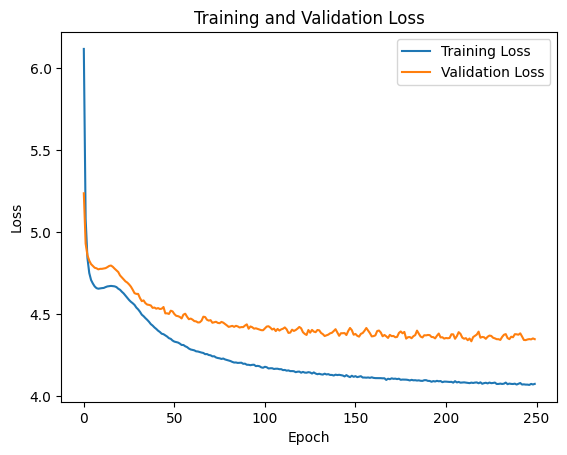

In [35]:
# TODO : Plot History
import matplotlib.pyplot as plt

plt.plot(t_loss, label='Training Loss')
plt.plot(ev_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


<hr>

# <p style="background-color:#1C647C; color:white;font-family:Gabriola;font-size:200%;text-align:center;border-radius:50px"><b>Test Model</b></p>

In [36]:
# TODO : translation
def translate_sentence(
    sentence: str,
    src_tokenizer: Tokenizer,
    trg_tokenizer: Tokenizer,
    model: nn.Module,
    device: torch.device,
    max_len: int = 50):
  
    model.eval()
    
    # encode sentence
    src = src_tokenizer.encode(sentence)
    # get src input as ids and attention_mask
    src_input = torch.tensor(src.ids).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(torch.tensor(src.attention_mask).unsqueeze(0).to(device))
  
    
    
    with torch.no_grad():
        enc_src = model.encoder(src_input, src_mask)
        
    trg_indices = [trg_tokenizer.token_to_id("[SOS]")]
    
    for i in range(max_len):
        trg_inputs = torch.tensor(trg_indices).unsqueeze(0).to(device)

        trg_mask = [1 if token != trg_tokenizer.token_to_id("[PAD]") else 0 for token in trg_indices]
        trg_mask = torch.tensor(trg_mask).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_mask)
        
        output, attention = model.decoder(trg_inputs, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indices.append(pred_token)

        if pred_token == trg_tokenizer.token_to_id("[EOS]"):
            break
        
            
    return trg_tokenizer.decode(trg_indices), attention
    

In [37]:
sentence = "مرحبا بك"
translation, atn = translate_sentence(
    sentence=sentence,
    src_tokenizer=ar_tokenizer,
    trg_tokenizer=en_tokenizer,
    model=model,
    device=var.device,
    max_len=var.TEXT['seq_len']
)
translation

'welcome .'

In [38]:
sentence = "المحولات هي قلب الذكاء الاصطناعي، فهي تسهم في تحسين الأداء وتعزيز الفهم في مجالات عدة"
translation, atn = translate_sentence(
    sentence=sentence,
    src_tokenizer=ar_tokenizer,
    trg_tokenizer=en_tokenizer,
    model=model,
    device=var.device,
    max_len=20
)
translation

'chinese in the of the of in the of of .'

In [39]:
sentence = "اهلا بك , اسمى زياد"
translation, atn = translate_sentence(
    sentence=sentence,
    src_tokenizer=ar_tokenizer,
    trg_tokenizer=en_tokenizer,
    model=model,
    device=var.device,
    max_len=20
)
translation

"let ' s help you ."

In [40]:
sentence = "هذه ترجمة من اللغة العربية الي الانجليزية"
translation, atn = translate_sentence(
    sentence=sentence,
    src_tokenizer=ar_tokenizer,
    trg_tokenizer=en_tokenizer,
    model=model,
    device=var.device,
    max_len=20
)
translation

'this english is a english english english is .'

<hr>

In [41]:
pip install --q arabic-reshaper python-bidi


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [42]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import arabic_reshaper
from bidi.algorithm import get_display

def display_attention(sentence, translation, attention, n_heads=var.TRANSFORMER['heads'], n_rows=var.TRANSFORMER['heads']//2, n_cols=2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(20, 40))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='inferno')

        ax.tick_params(labelsize=12)

        # Reversing the Arabic words and reshaping them
        reversed_sentence = [get_display(arabic_reshaper.reshape(word)) for word in reversed(sentence)]
        reversed_translation = [get_display(arabic_reshaper.reshape(word)) for word in reversed(translation)]

        ax.set_xticklabels(['']+['<sos>']+reversed_sentence+['<eos>'], 
                           rotation=45, fontdict={'fontsize': 10}, ha='left')
        ax.set_yticklabels(['']+reversed_translation, fontdict={'fontsize': 10}, ha='right')

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        # Add annotations
        for (i, j), val in np.ndenumerate(_attention):
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=8)

    plt.show()
    plt.close()


/tmp/ipykernel_24/2698526850.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+reversed_sentence+['<eos>'],
/tmp/ipykernel_24/2698526850.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+reversed_translation, fontdict={'fontsize': 10}, ha='right')


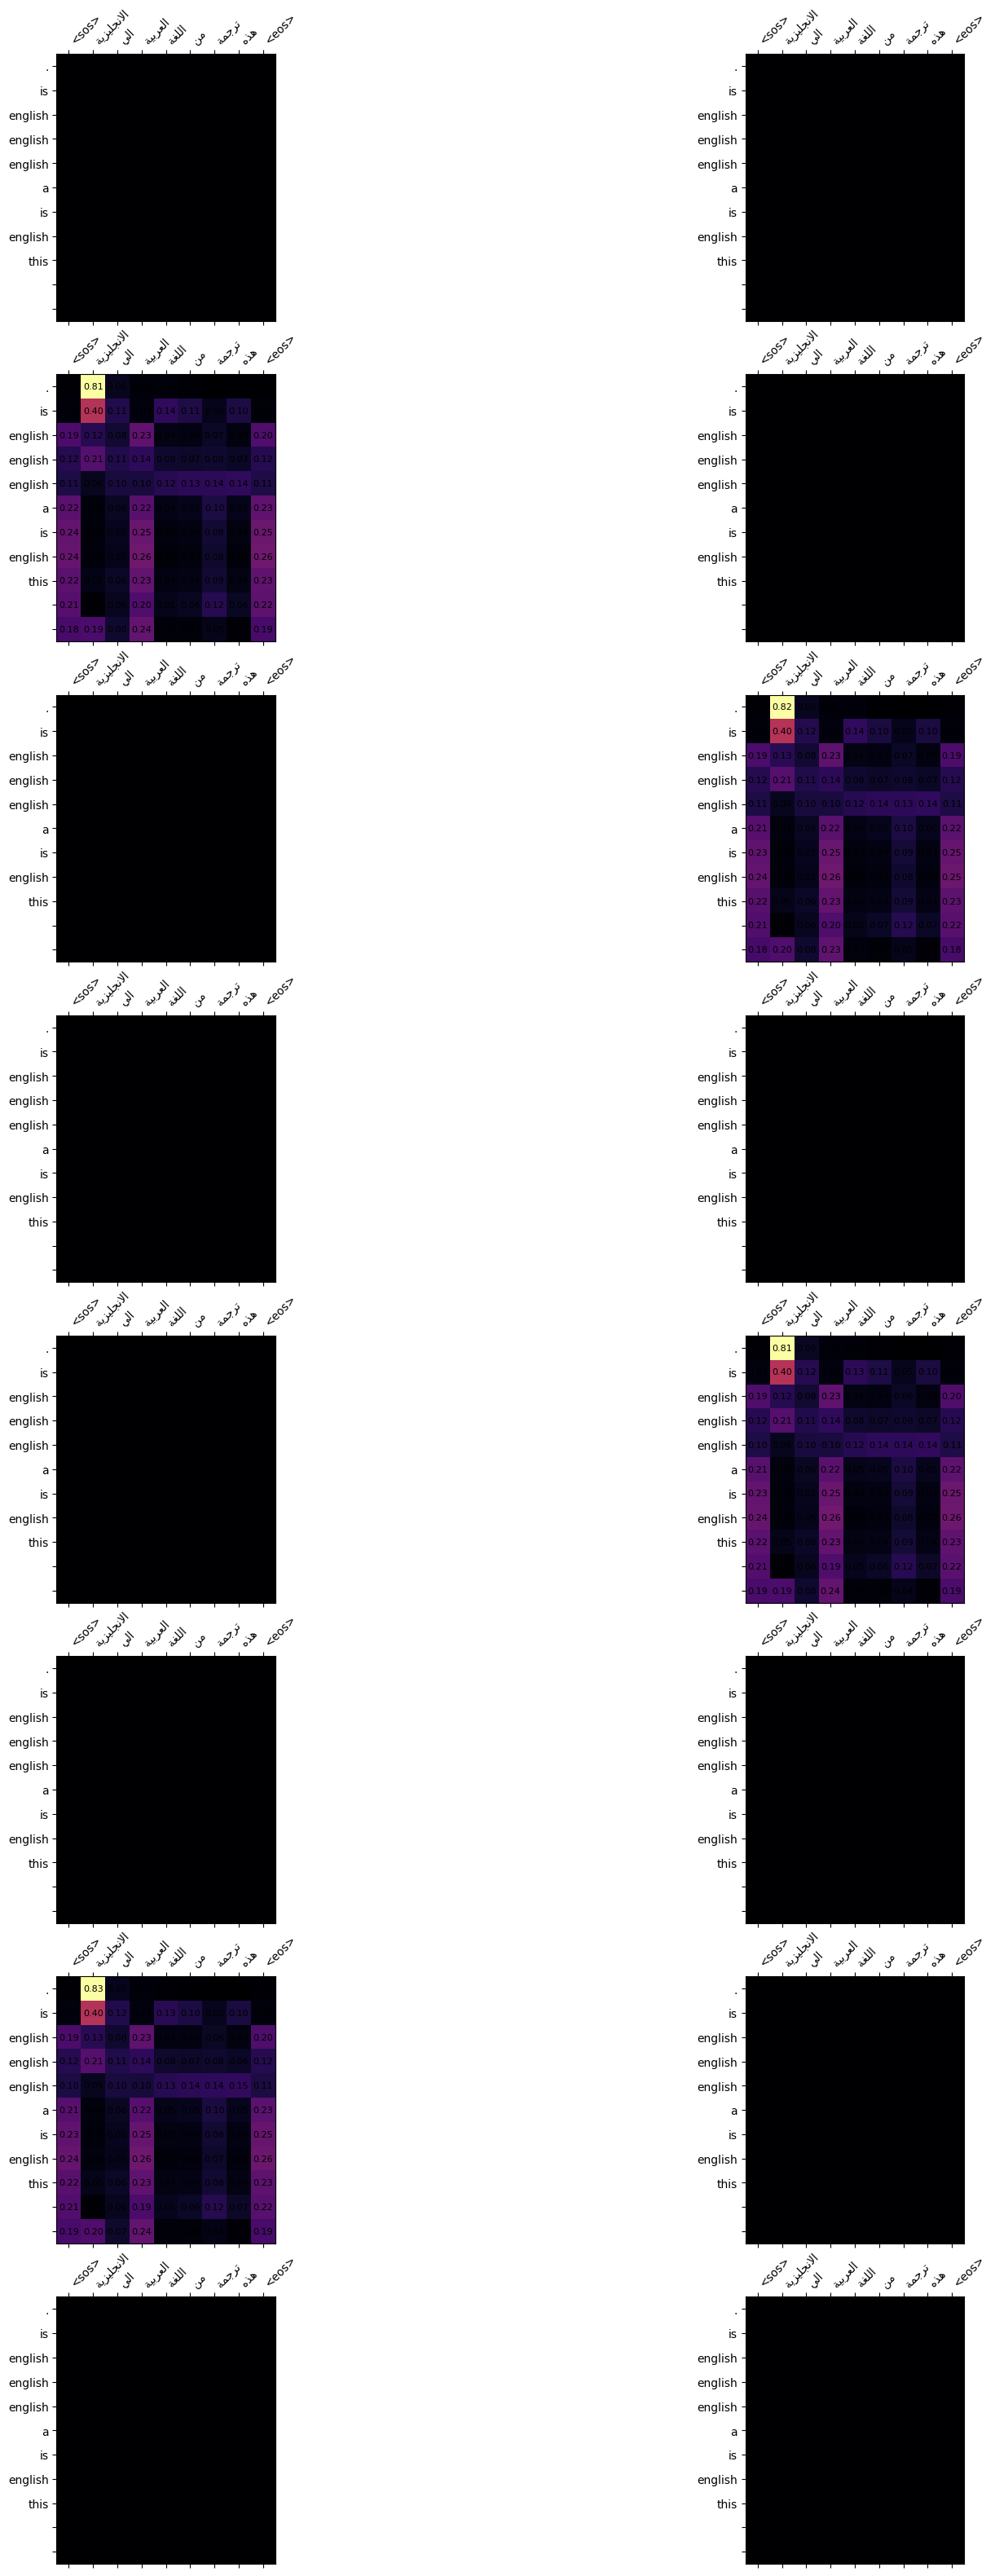

In [43]:
src = sentence.split(" ")
trg = translation.split(" ")
display_attention(src, trg, atn)